QMAP Banana Data 

Have fun!

Packages

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FastICA
from sklearn.cross_decomposition import PLSRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import shapiro, anderson, norm

import umap as U

read file

In [9]:
# mac # df = pd.read_excel(r'/Users/s/datasets/banana-gc-matrix.xlsx', header=0)
df = pd.read_excel(r"C:\Users\uqkmuroi\Desktop\banana-gc-matrix.xlsx", header=0) # work

This below is for this particular dataset to remove last 7 columns with metabolome name but no values

In [10]:
# Drop last 7 columns as they are empty (NaN)
df = df.dropna(axis=1, how='any')

These are some tests to check how log transform. This is done at each column, and 'column_id' can't be used to check how metabolite varies between sample. This is imoprtant as many metabolite measurements span large positive numbers and log transformation normalises data amenable to machine learning and regression algorithms.

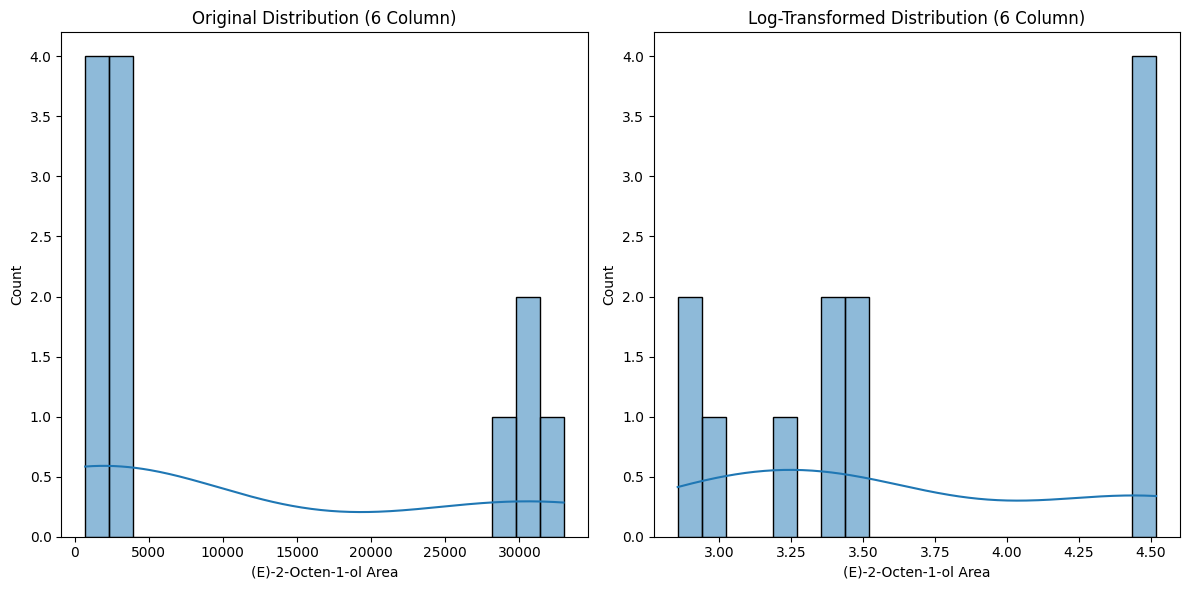

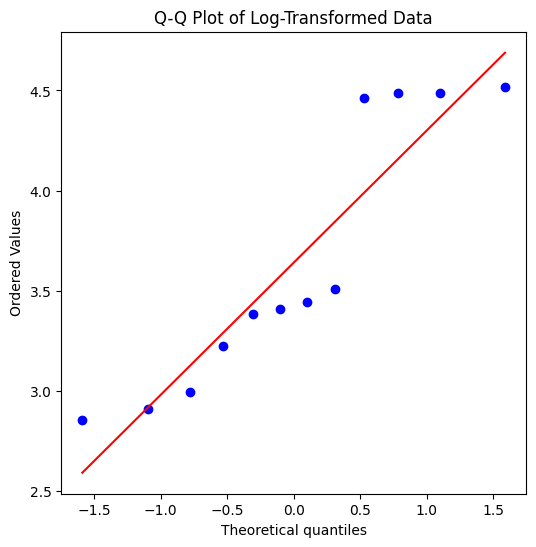

Shapiro-Wilk Test Statistic: 0.8293155762420087, p-value: 0.020581882855211536
Anderson-Darling Test Statistic: 0.8728425599320317
Critical Values: [0.497 0.566 0.679 0.792 0.942]
Significance Level: [15.  10.   5.   2.5  1. ]


In [11]:
# Select only numeric columns
numeric_df = df.select_dtypes(include=['number'])

# Apply log10 to the numeric columns
log_transformed_df = np.log10(numeric_df)


column_id = 5


# Plot histograms of the original data and log-transformed data
plt.figure(figsize=(12, 6))

# Plot the original data's first column (for example)
plt.subplot(1, 2, 1)
sns.histplot(numeric_df.iloc[:,column_id], kde=True, bins=20)
plt.title('Original Distribution ('+ str(column_id+1) +' Column)')

# Plot the log-transformed data
plt.subplot(1, 2, 2)
sns.histplot(log_transformed_df.iloc[:, column_id], kde=True, bins=20)
plt.title('Log-Transformed Distribution ('+ str(column_id+1) + ' Column)')

plt.tight_layout()
plt.show()

# Q-Q plot of the log-transformed data
import scipy.stats as stats
plt.figure(figsize=(6, 6))
stats.probplot(log_transformed_df.iloc[:, column_id], dist="norm", plot=plt)
plt.title('Q-Q Plot of Log-Transformed Data')
plt.show()

# Perform Shapiro-Wilk test for normality on log-transformed data (e.g., first column)
stat, p_value = shapiro(log_transformed_df.iloc[:, column_id].dropna())  # drop NaN values if any
print(f'Shapiro-Wilk Test Statistic: {stat}, p-value: {p_value}')

# Perform Anderson-Darling test for normality
result = anderson(log_transformed_df.iloc[:, column_id].dropna(), dist='norm')
print(f'Anderson-Darling Test Statistic: {result.statistic}')
print(f'Critical Values: {result.critical_values}')
print(f'Significance Level: {result.significance_level}')

# If p-value of Shapiro-Wilk is high, or Anderson-Darling statistic is below the critical value,
# the log-transformed data may be considered normally distributed, suggesting log-normal distribution.


Set Index on df so we can sample from the names of the banana type and sample number

In [12]:
# Set Index
df = df.set_index('Unnamed: 0')


log 10 df value (if previous analysis shows good correlation to model

In [13]:
log_df = np.log10(df)

Check the dataset

In [14]:
print(log_df)

                        (2E  6Z)-nona-2  6-dienal Area  \
Unnamed: 0                                               
Green_Banana_1     5.561109    2.480007       5.142777   
Ripe_Banana_3      5.215490    4.165719       4.227784   
Overripe_Banana_2  4.518251    3.302547       3.668572   
Green_Banana_4     5.278790    3.058426       5.165304   
Ripe_Banana_5      5.086741    4.386659       4.193820   
Overripe_Banana_1  4.748149    3.327767       3.619093   
Ripe_Banana_2      5.073355    4.162056       3.495960   
Green_Banana_3     4.728532    3.081347       4.725838   
Overripe_Banana_3  4.508786    3.451172       3.827111   
Green_Banana_2     4.835405    2.984977       4.999043   
Overripe_Banana_4  4.303995    3.392697       4.010427   
Ripe_Banana_1      5.155309    4.106531       3.709270   

                   (3Z)-3-Hexenyl acetate Area  (E)-2-Nonenal Area  \
Unnamed: 0                                                           
Green_Banana_1                        3.074085 

Assuming everything went well to here you have df and log_df. 
df = original
log_df = log10 transformed data

In [15]:
log_num_df = np.delete(log_df, 0,0)
print(log_num_df)

[[5.21548951 4.16571903 4.2277839  4.32263271 2.71600334 4.48715252
  2.80140371 4.02995164 4.86507435 5.21307394 4.60672522 5.51298707
  3.56122068 2.15228834 3.80147231 3.7000977  2.82412583 3.71583628
  4.38904198 4.51236416 5.25135346 6.31525706 7.62522306 5.28859125
  6.09403767 3.36040405 5.15002843 3.71899964 2.95520654 5.86523489
  3.1319393  2.64246452 5.01564053 4.487831   4.68336228 5.04931108
  3.681603   4.4700575  5.47634897 3.15442397 6.25428336 3.1354507
  3.10754913 3.22479196 3.39759243 4.43174963 3.14457421 3.10448711
  3.7909182  7.53384704 5.88599975 4.91156773 5.72064296 7.62039042
  6.31572627 7.60301743 3.46269741 4.33955081 5.43429739 4.21729966
  3.50866436 3.88246761 5.03496918 3.3767594  3.25309559 3.28352736
  3.25188145 4.17336112 4.86651181 6.49181187 4.48250199]
 [4.51825065 3.30254737 3.66857227 4.58446692 1.91381385 3.22659991
  2.72916479 3.75273969 3.39497672 6.04793379 4.0246088  5.73567394
  4.15121658 3.15715444 3.60010126 4.14363924 1.86923172 2.

And now we do the PCA analysis

Explained Variance for each Principal Component:
[45.28938997 23.83025309  3.43314104]

Explained Variance Ratio for each Principal Component:
[0.57988976 0.30512488 0.04395827]


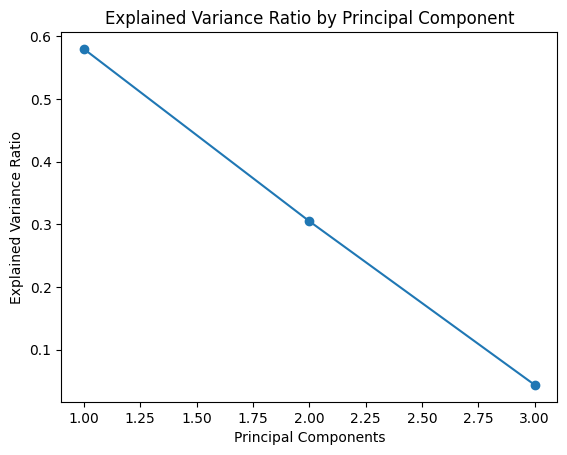

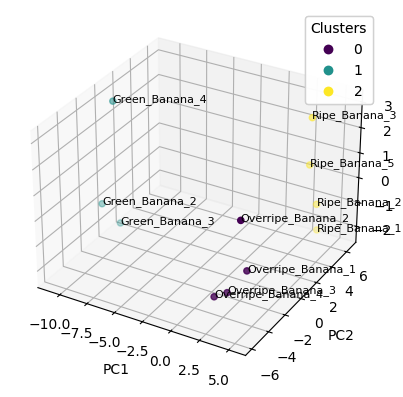

In [17]:

scaler= StandardScaler()
scaled_data = scaler.fit_transform(log_num_df)

#Principal Component Analysis
pca = PCA(n_components =3)
pca_result = pca.fit_transform(scaled_data)

# Explained Variance and Explained Variance Ratio
print("Explained Variance for each Principal Component:")
print(pca.explained_variance_)

print("\nExplained Variance Ratio for each Principal Component:")
print(pca.explained_variance_ratio_)

# Plot explained variance and its ratio
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_, marker='o')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Principal Component')
plt.show()


pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2', 'PC3'])

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # You can adjust the number of clusters as needed
pca_df['Cluster'] = kmeans.fit_predict(pca_df[['PC1', 'PC2', 'PC3']])

# Use index from log_df or df for labelling
pca_df['Label'] = log_df.index[-len(pca_df):]

# 3D plot of the PCA results colored by the cluster labels
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], c=pca_df['Cluster'], cmap='viridis')

#Add labels to the points (use 'Label' column from pca_df)
for i, txt in enumerate(pca_df['Label']):
    ax.text(pca_df['PC1'][i], pca_df['PC2'][i], pca_df['PC3'][i], str(txt), size=8, color='black')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

# Add a legend
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.show()
